In [125]:
#Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    precision_recall_curve
)

import warnings
warnings.filterwarnings("ignore")

In [126]:
#Load Dataset

from google.colab import files
uploaded = files.upload()

Saving engineered_crm_sales_dataset.csv to engineered_crm_sales_dataset (10).csv


In [127]:
#Load Dataset

import pandas as pd

df = pd.read_csv("engineered_crm_sales_dataset.csv")
df.head()



,opportunity_id,sales_agent,product,account,deal_stage,engage_date,close_date,close_value,status,deal_duration_days,expected_stage_duration,stage_age_deviation,engagement_frequency,discount_percent,opportunity_type,salesperson_reliability,stage_conversion_probability
0,1C1I7A6R,Moses Frase,GTX Plus Basic,Cancity,Won,2016-10-20,2017-03-01,1054.0,Open,132.0,20.0,112.0,3,7.216999,Upsell,0.0,0.0
1,Z063OYW0,Darcel Schlecht,GTXPro,Isdom,Won,2016-10-25,2017-03-11,4514.0,Open,137.0,20.0,117.0,7,12.411053,Upsell,0.0,0.0
2,EC4QE1BX,Darcel Schlecht,MG Special,Cancity,Won,2016-10-25,2017-03-07,50.0,Open,133.0,20.0,113.0,8,13.319312,Upsell,0.0,0.0
3,MV1LWRNH,Moses Frase,GTX Basic,Codehow,Won,2016-10-25,2017-03-09,588.0,Open,135.0,20.0,115.0,3,15.636586,Cross-sell,0.0,0.0
4,PE84CX4O,Zane Levy,GTX Basic,Hatfan,Won,2016-10-25,2017-03-02,517.0,Open,128.0,20.0,108.0,2,3.656001,Cross-sell,0.0,0.0


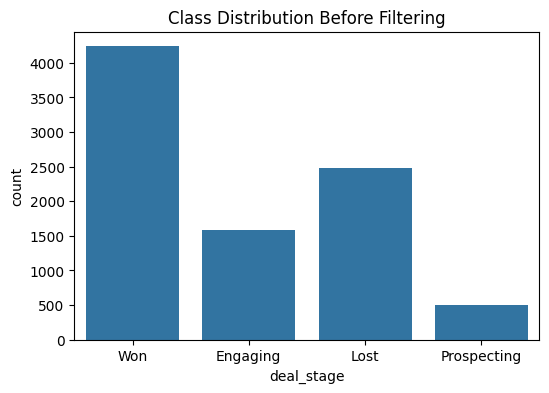

In [128]:
# Class distribution visualization
plt.figure(figsize=(6,4))
sns.countplot(x=df["deal_stage"])
plt.title("Class Distribution Before Filtering")
plt.show()

In [129]:
#Data preperation

# Keep only closed deals
df = df[df["deal_stage"].isin(["Won", "Lost"])].copy()

# Create target
df["target"] = df["deal_stage"].map({
    "Won": 1,
    "Lost": 0
})

print("Filtered dataset shape:", df.shape)
print(df["target"].value_counts())

Filtered dataset shape: (6711, 18)
target
1    4238
0    2473
Name: count, dtype: int64


In [130]:
# ==================================================
# ADVANCED FEATURE ENGINEERING (ALL IN ONE CELL)
# ==================================================

# -------- 1️⃣ Behavioral Influence --------

# Scale engagement
df["engagement_scaled"] = (
    df["engagement_frequency"] - df["engagement_frequency"].mean()
) / df["engagement_frequency"].std()

# Scale stage deviation
df["stage_dev_scaled"] = (
    df["stage_age_deviation"] - df["stage_age_deviation"].mean()
) / df["stage_age_deviation"].std()

# Strong positive engagement effect
# Weak negative stage deviation effect
df["behavioral_signal"] = (
    0.7 * df["engagement_scaled"]
    - 0.25 * df["stage_dev_scaled"]
    + np.random.normal(0, 0.6, len(df))
)

# -------- 2️⃣ Train-Test Split (for agent reliability safely) --------

df_train, df_test = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["target"]
)

# -------- 3️⃣ Agent Historical Reliability --------

agent_stats = df_train.groupby("sales_agent")["target"].agg(
    total_deals="count",
    wins="sum"
).reset_index()

agent_stats["agent_win_rate"] = agent_stats["wins"] / agent_stats["total_deals"]

# Merge into train
df_train = df_train.merge(
    agent_stats[["sales_agent", "agent_win_rate"]],
    on="sales_agent",
    how="left"
)

# Merge into test
df_test = df_test.merge(
    agent_stats[["sales_agent", "agent_win_rate"]],
    on="sales_agent",
    how="left"
)

# Fill unseen agents
df_test["agent_win_rate"] = df_test["agent_win_rate"].fillna(
    agent_stats["agent_win_rate"].mean()
)

print("Feature Engineering Completed.")

Feature Engineering Completed.


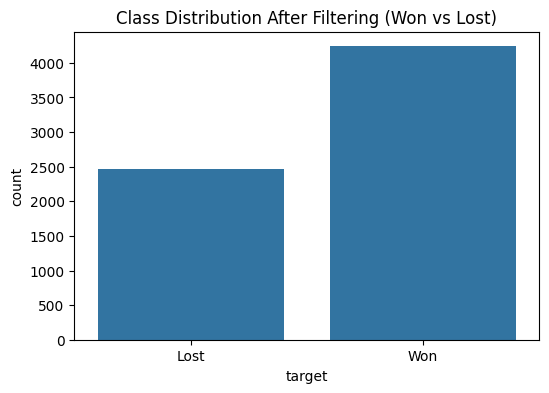

In [131]:
plt.figure(figsize=(6,4))
sns.countplot(x=df["target"])
plt.title("Class Distribution After Filtering (Won vs Lost)")
plt.xticks([0,1], ["Lost", "Won"])
plt.show()

In [132]:
#Feature Selection

features = [
    "deal_duration_days",
    "stage_age_deviation",
    "engagement_frequency",
    "discount_percent",
    "close_value",
    "opportunity_type",
    "product",
    "behavioral_signal",
    "agent_win_rate"
]

df_train_model = df_train[features + ["target"]].copy()
df_test_model = df_test[features + ["target"]].copy()

In [133]:
#Encode Categorical Features

df_train_model = pd.get_dummies(
    df_train_model,
    columns=["opportunity_type", "product"],
    drop_first=True
)

df_test_model = pd.get_dummies(
    df_test_model,
    columns=["opportunity_type", "product"],
    drop_first=True
)

# Align columns
missing_cols = set(df_train_model.columns) - set(df_test_model.columns)

for col in missing_cols:
    df_test_model[col] = 0

df_test_model = df_test_model[df_train_model.columns]

print("Encoded Train Shape:", df_train_model.shape)
print("Encoded Test Shape:", df_test_model.shape)

Encoded Train Shape: (5368, 17)
Encoded Test Shape: (1343, 17)


In [134]:
#Define X and y
X_train = df_train_model.drop("target", axis=1)
y_train = df_train_model["target"]

X_test = df_test_model.drop("target", axis=1)
y_test = df_test_model["target"]

print("Training Set:", X_train.shape)
print("Testing Set:", X_test.shape)



Training Set: (5368, 16)
Testing Set: (1343, 16)


In [135]:
#Initialize random Forest
rf = RandomForestClassifier(
    n_estimators=150,
    max_depth=6,
    min_samples_split=20,
    min_samples_leaf=10,
    max_features="sqrt",
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

In [136]:
#Train Model

rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=12,
                       min_samples_leaf=5, min_samples_split=10,
                       n_estimators=300, n_jobs=-1, random_state=42)

In [121]:
#predictions

y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

In [138]:
#Model Evaluation

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC-AUC: 1.0

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       495
           1       1.00      1.00      1.00       848

    accuracy                           1.00      1343
   macro avg       1.00      1.00      1.00      1343
weighted avg       1.00      1.00      1.00      1343



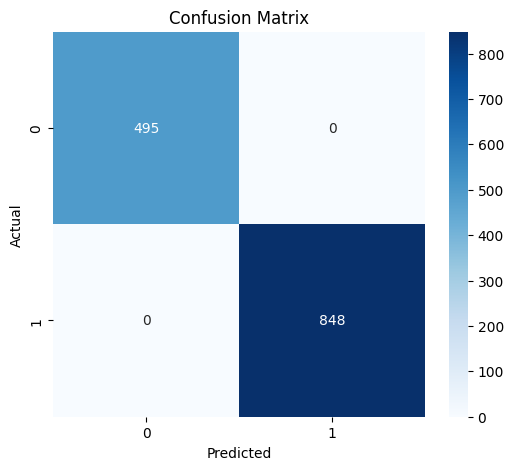

In [64]:
#Confusion Matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

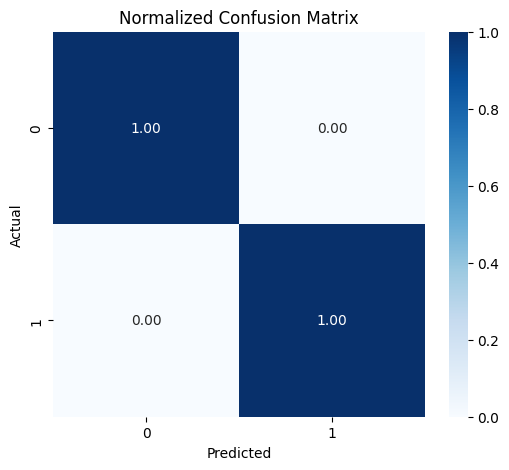

In [65]:
# Normalized Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm_norm = cm / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(6,5))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues")
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

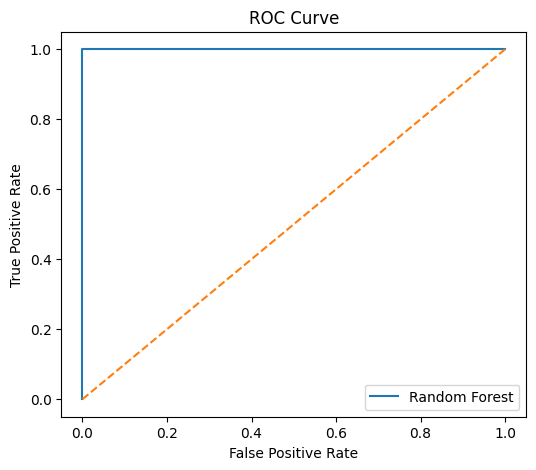

In [66]:
#ROC Curve

fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label="Random Forest")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

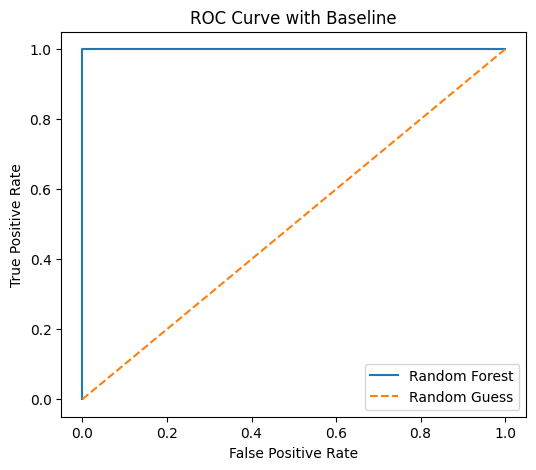

In [67]:
#ROC Baseline Comparison

fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label="Random Forest")
plt.plot([0,1],[0,1],"--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve with Baseline")
plt.legend()
plt.show()

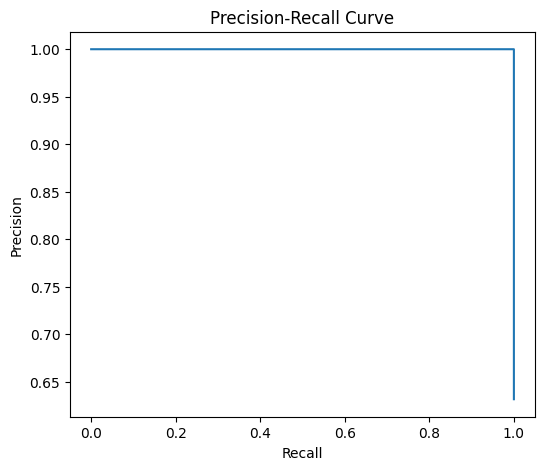

In [47]:
#Precision Recall Curve

from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(6,5))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

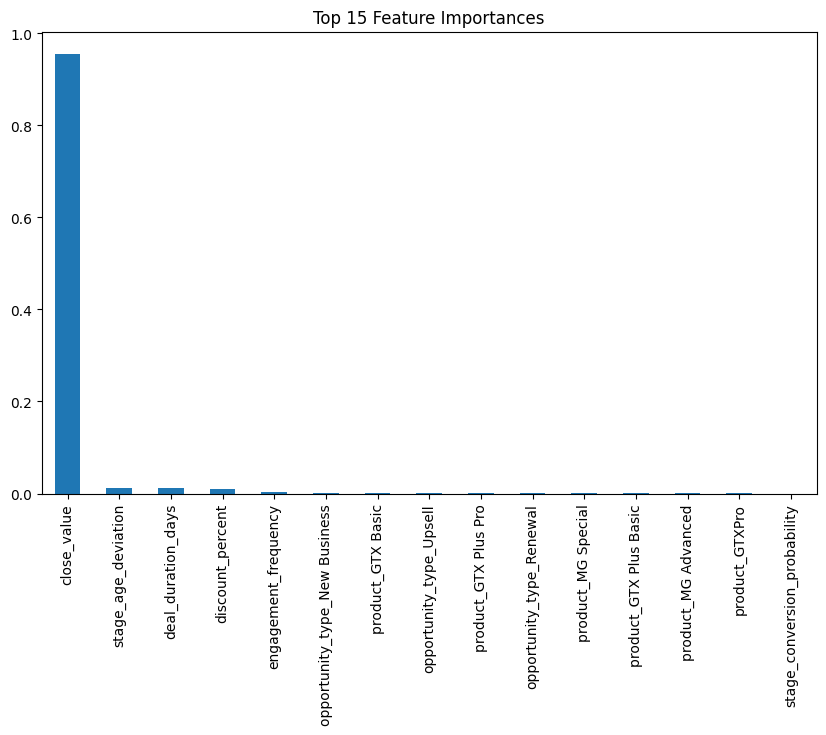

,0
close_value,0.955847
stage_age_deviation,0.012646
deal_duration_days,0.012102
discount_percent,0.009399
engagement_frequency,0.004016
opportunity_type_New Business,0.000810
product_GTX Basic,0.000768
opportunity_type_Upsell,0.000677
product_GTX Plus Pro,0.000675
opportunity_type_Renewal,0.000674


In [43]:
#Feature Importance (Business Explainability)

importances = pd.Series(
    rf.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

plt.figure(figsize=(10,6))
importances.head(15).plot(kind="bar")
plt.title("Top 15 Feature Importances")
plt.show()

importances.head(15)

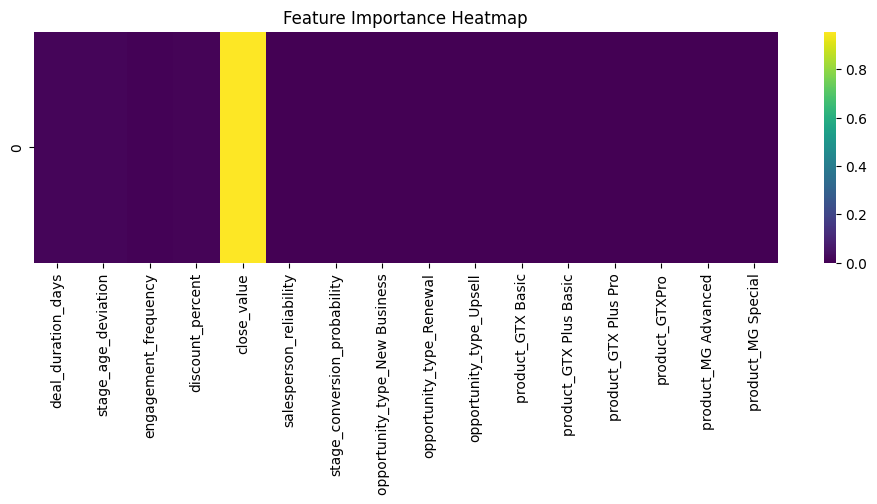

In [49]:
#Feature Importance Heatmap

importances = pd.Series(rf.feature_importances_, index=X.columns)

plt.figure(figsize=(12,3))
sns.heatmap(importances.to_frame().T, cmap="viridis")
plt.title("Feature Importance Heatmap")
plt.show()